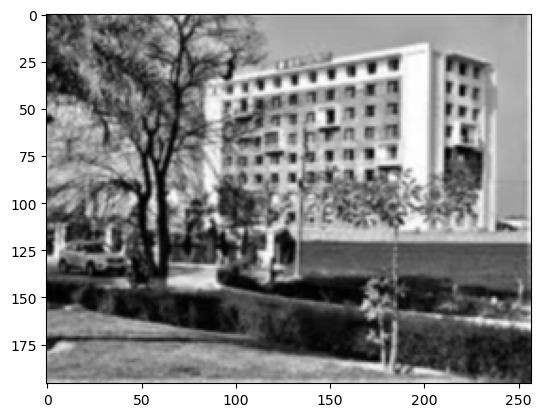

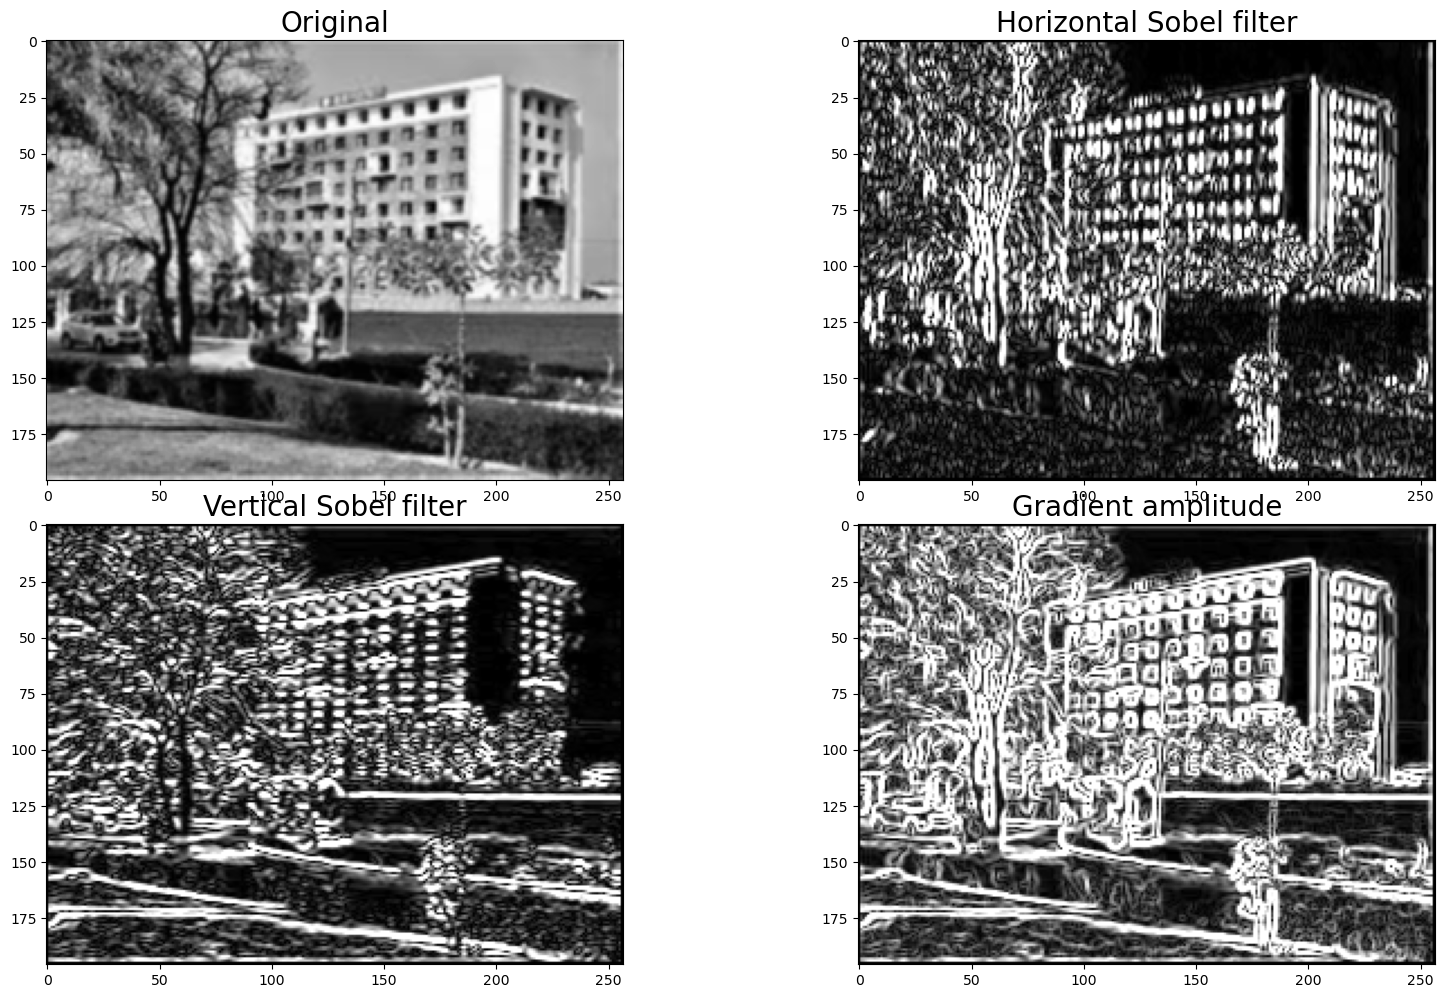

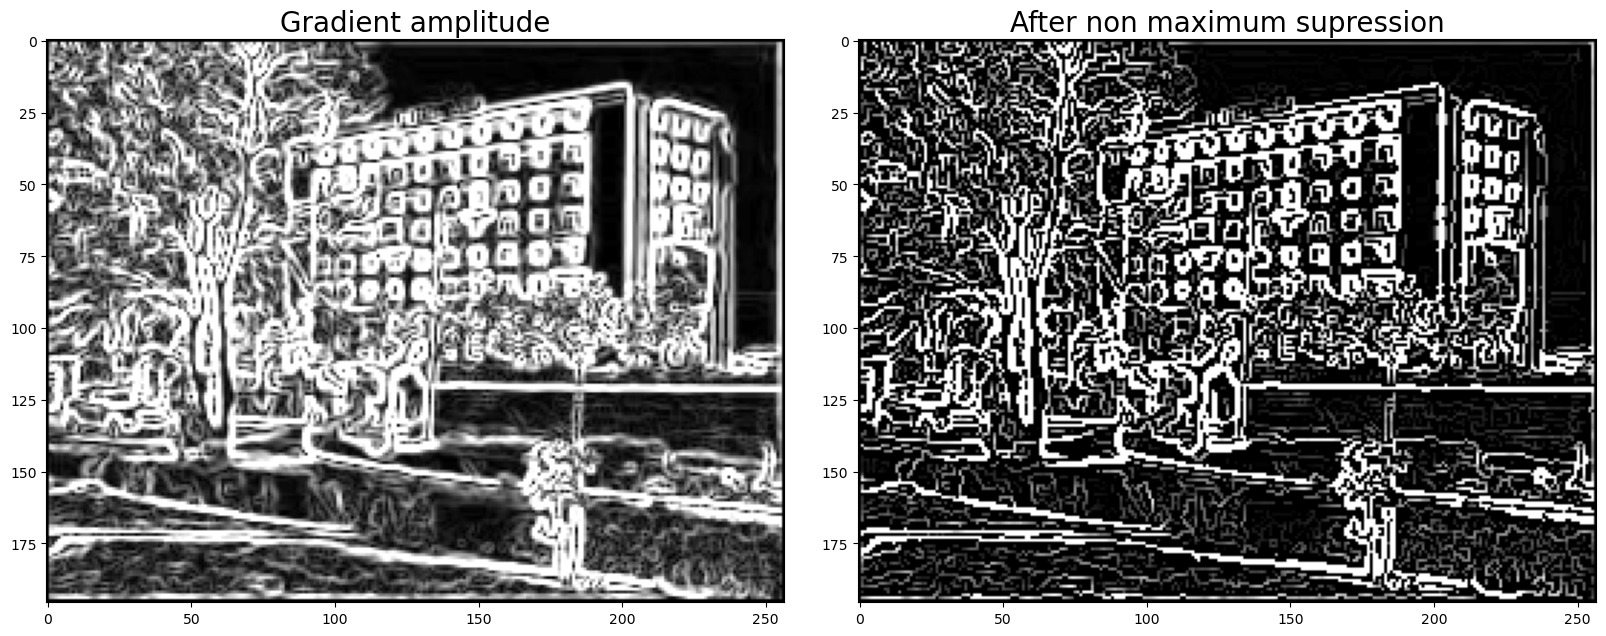

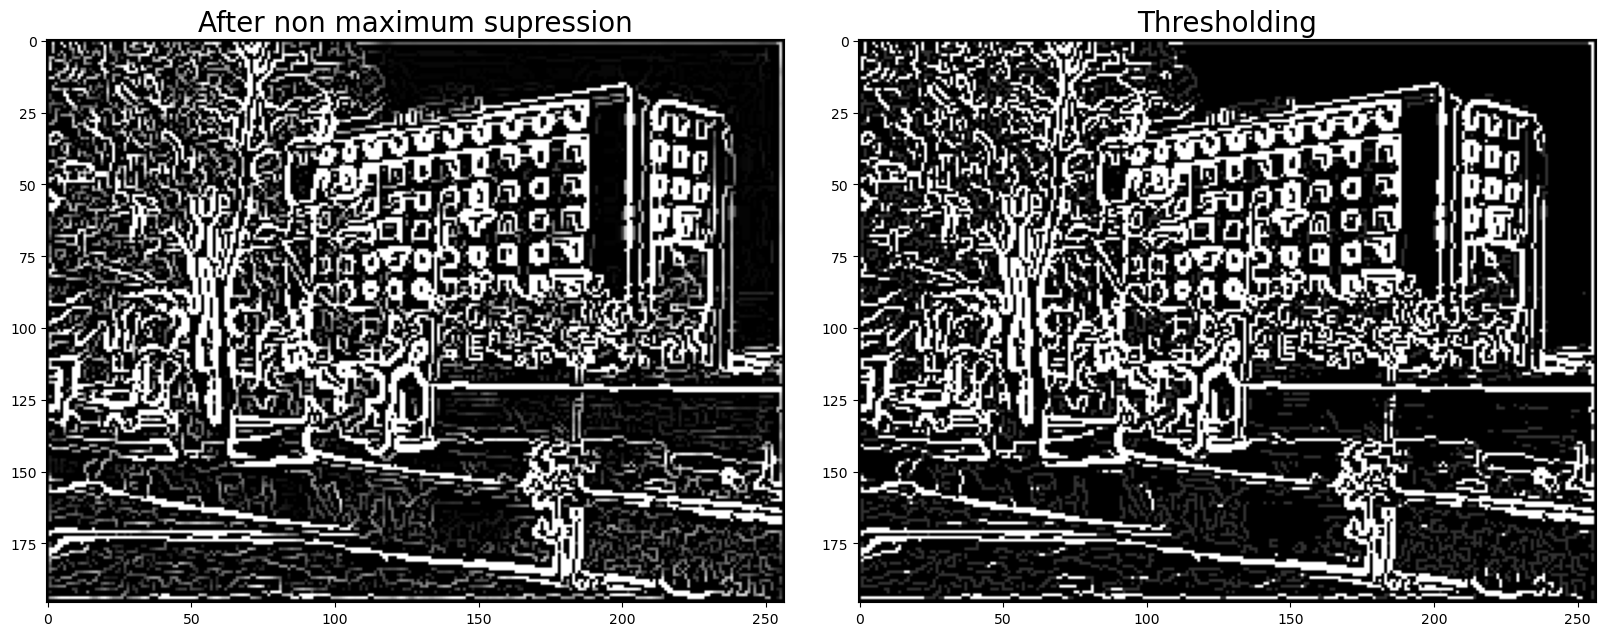

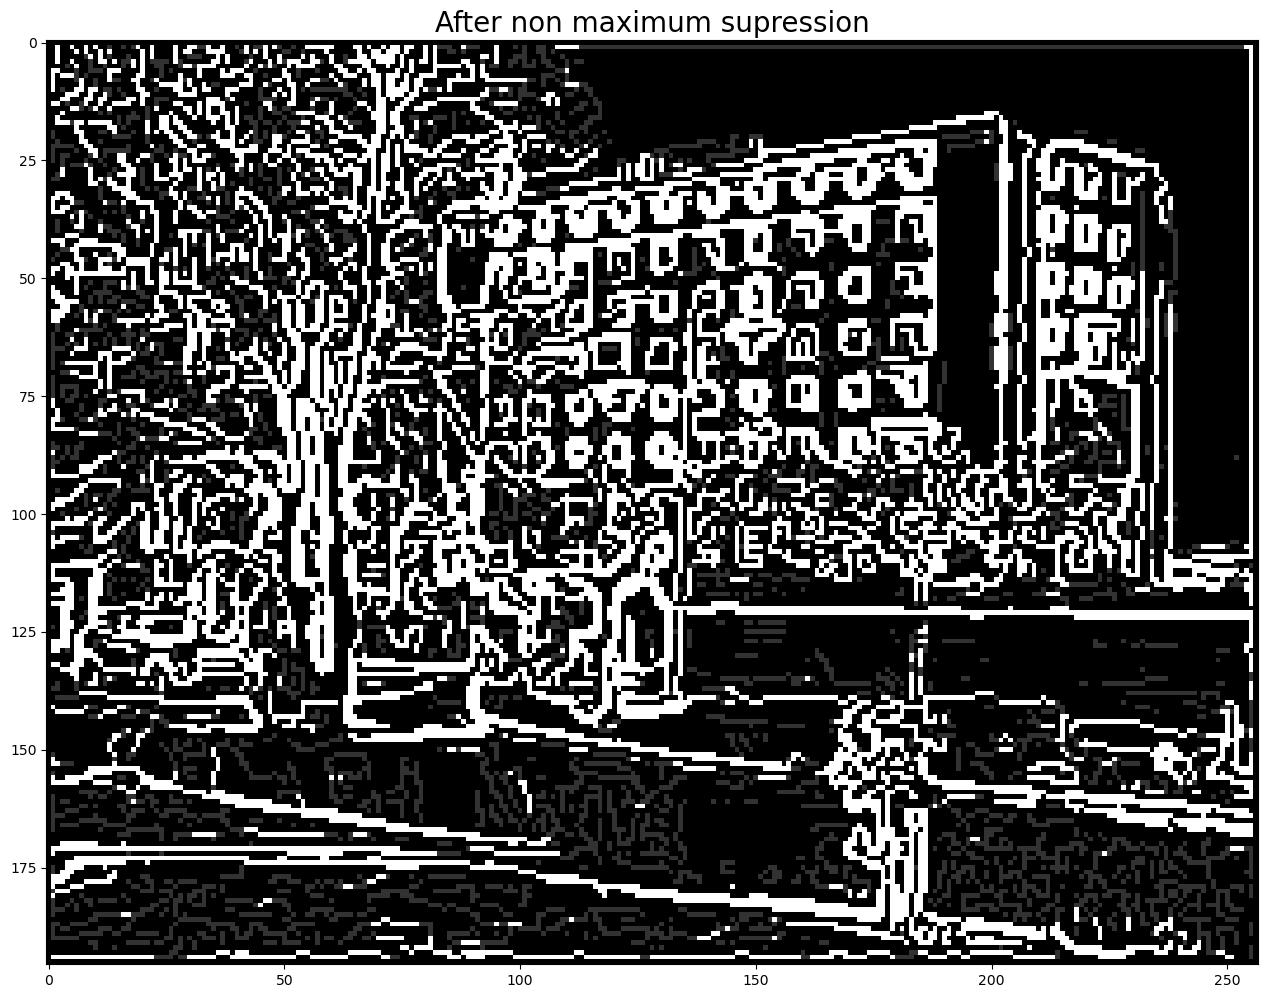

<Figure size 2000x1200 with 0 Axes>

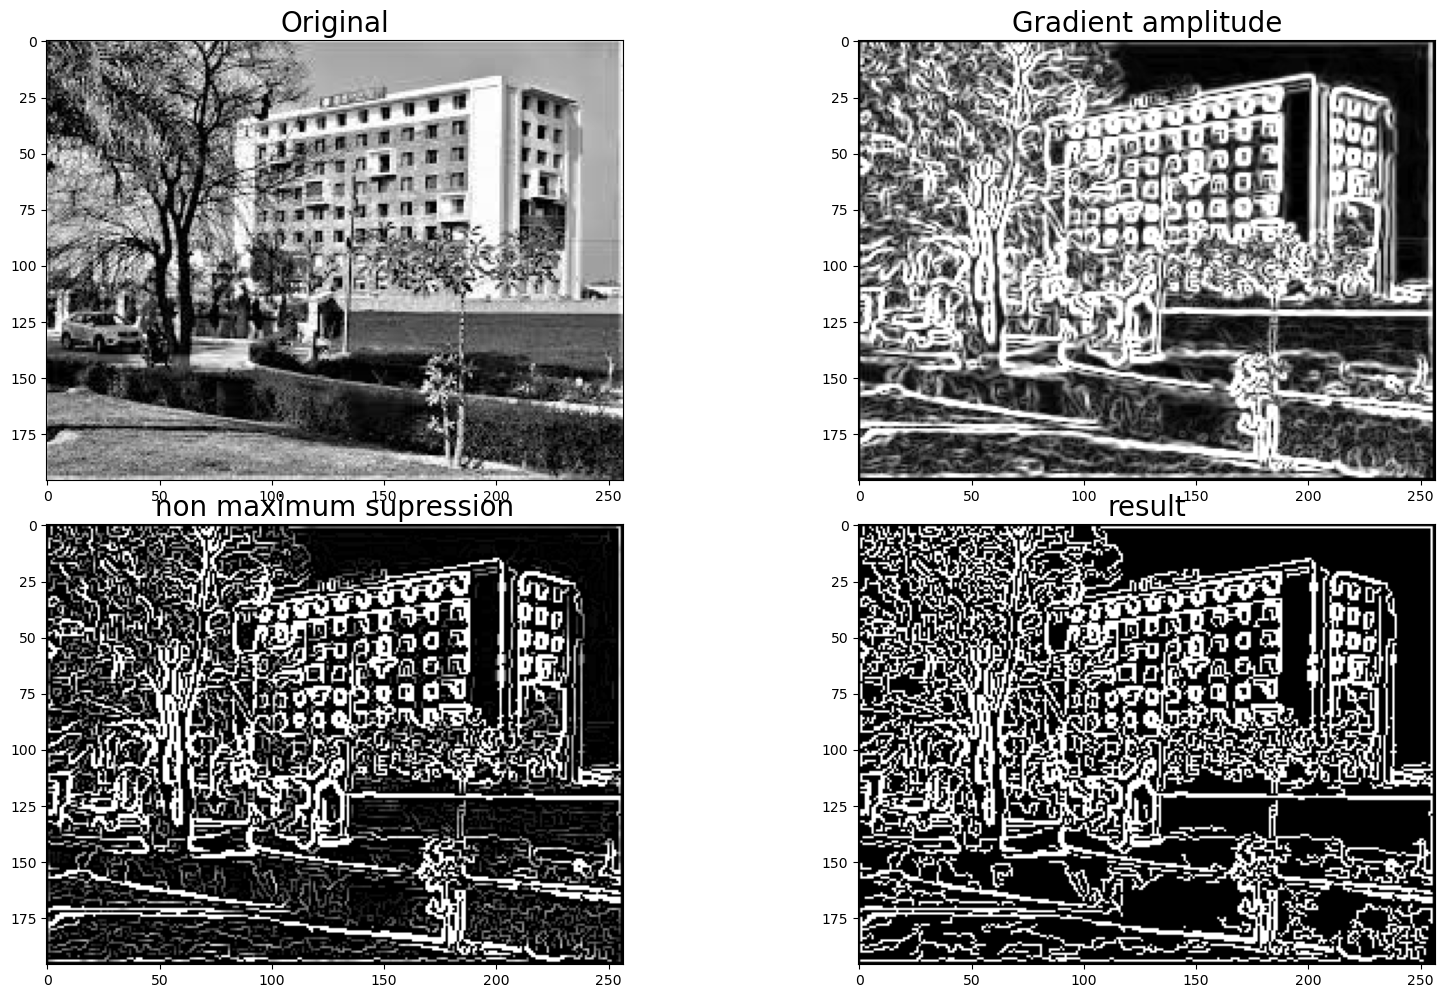

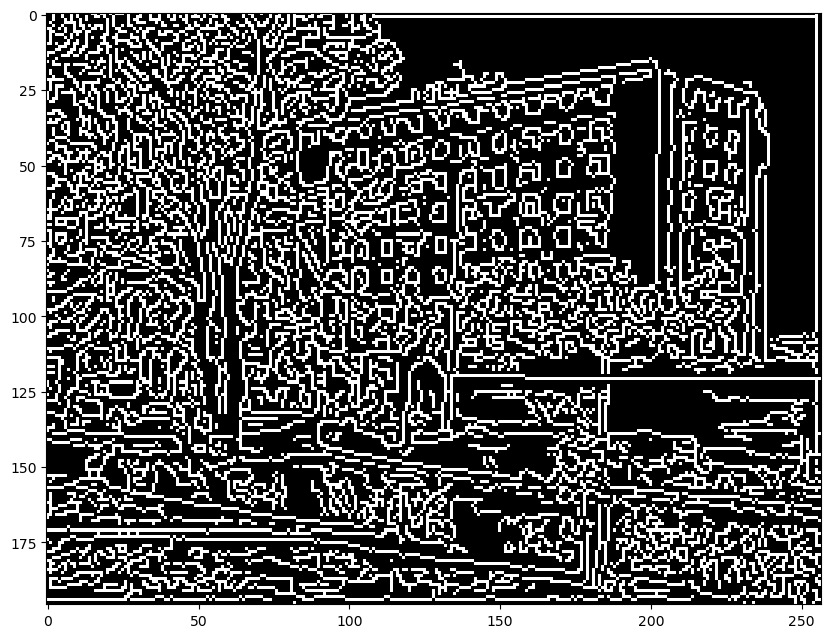

In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def padding_img(img,k_size,style='edge'):
  return np.pad(img,k_size,style)

def gaussian_kernel(size):
    sigma=0.3*((size-1)*0.5 - 1) + 0.8
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]   
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2)))     
    return g/np.sum(g)

img_org = cv2.imread("C:\\Users\\ramup\\OneDrive\\Desktop\\Ct university5.jpeg",0)
KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    for x in range(row):
        for y in range(col):
          respixel=0
          for i in range(KernelSize):
              for j in range(KernelSize):
                  pixel=padimg[x+i,y+j]* Gaussian_Kernel[i][j]
                  respixel+= pixel         
          resx[x,y]=respixel
    return resx

img = Gaussian_Filter(KernelSize,img_org)
plt.imshow(img ,cmap='gray')
plt.show()

img.shape,img.dtype


def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    Gx = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))

    for img_region, i, j in iterate_regions(img, 3):
        if filtering_type == 'dx':
            Gx[i, j] += np.sum(img_region * horizontal)
        elif filtering_type == 'dy':
            Gy[i, j] += np.sum(img_region * vertical)
        elif filtering_type == 'magnitude':
            Gx[i, j] += np.sum(img_region * horizontal)
            Gy[i, j] += np.sum(img_region * vertical)

    gradient = np.sqrt(Gx**2 + Gy**2)
    gradient = np.pad(gradient, (1, 1), 'constant')
    angle = np.arctan2(Gy, Gx)
    angle = np.pad(angle, (1, 1), 'constant')

    output = (255 * np.int32(gradient > 255) + gradient * np.int32(gradient <= 255))
    angle += math.pi * np.int32(angle < 0)

    return output, angle


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j
sobel_y,_ = sobel(img, 'dy')
sobel_x,_ = sobel(img, 'dx')
sobel_m,_ = sobel(img, 'magnitude')
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.subplot(2,2,1)
plt.title('Original' ,fontsize=20)
plt.imshow(img, cmap='gray')

plt.subplot(2,2,2)
plt.title('Horizontal Sobel filter',fontsize=20)
plt.imshow(sobel_x, cmap='gray')

plt.subplot(2,2,3)
plt.title('Vertical Sobel filter',fontsize=20)
plt.imshow(sobel_y, cmap='gray')

plt.subplot(2,2,4)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(sobel_m, cmap='gray')

plt.show()




def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
          #0~22.5 degrees, 157.5~180 degrees is the 0 degree interval
            if (angle[j, i] >= 0 and angle[j, i] < 22.5 / 180 * math.pi) or (angle[j, i] >= 157.5 / 180 * math.pi and angle[j, i] < math.pi):
                if gradient[j, i] < gradient[j, i-1] or gradient[j, i] < gradient[j, i+1]:
                    gradient_copy[j, i] = 0
          #22.5~67.5 degrees is the 45 degree interval
            elif angle[j, i] >= 22.5 / 180 * math.pi and angle[j, i] < 67.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j-1, i-1] or gradient[j, i] < gradient[j+1, i+1]:
                    gradient_copy[j, i] = 0
           #67.5~112.5 degrees is the 90-degree interval
            elif angle[j, i] >= 67.5 / 180 * math.pi and angle[j, i] < 112.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j-1, i] or gradient[j, i] < gradient[j+1, i]:
                    gradient_copy[j, i] = 0
            #112.5~157.5 degrees is the 135 degree interval
            elif angle[j, i] >= 112.5 / 180 * math.pi and angle[j, i] < 157.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j+1, i-1] or gradient[j, i] < gradient[j-1, i+1]:
                    gradient_copy[j, i] = 0            
    # output = np.clip(gradient_copy,0,255)    
    return gradient_copy

gradient,angle = sobel(img, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

plt.subplot(1,2,1)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(gradient, cmap='gray')

plt.subplot(1,2,2)
plt.title('After non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.show()


def seperate(img, minimum = 60, maximum = 180):
    output = img.copy()
    output[(output<maximum)*(output>=minimum)]=minimum
    output[output>=maximum]=255
    output[output<minimum] = 0   
    return output
weak = 50
thresholding = seperate(After_non_maximum_supression, minimum = weak, maximum = weak*3)
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

plt.subplot(1,2,2)
plt.title('Thresholding',fontsize=20)
plt.imshow(thresholding, cmap='gray')

plt.subplot(1,2,1)
plt.title('After non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.show()

fig = plt.figure(figsize=(20,12))
plt.title('After non maximum supression',fontsize=20)
plt.imshow(thresholding, cmap='gray')
plt.show()

def Connect(img,weak=60):
  height,width = img.shape
  output = img.copy()
  xx,yy = np.where(img == 255)
  xx = xx.tolist()
  yy = yy.tolist()
  while len(xx) >0:
    tx = xx.pop()
    ty = yy.pop()
    if tx+1 <= height and tx-1>=0 and ty+1<=width and ty-1>=0:
      newx,newy = np.where(output[tx-1: tx+1+1,ty-1:ty+1+1]==weak)
      newx = newx+tx-1
      newy = newy+ty-1    
      if len(newx)>0:
        output[newx,newy]=255
        xx = newx.tolist() + xx
        yy = newy.tolist() + yy
  output[output==weak]=0
  return output
dst_img = Connect(thresholding,weak)
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.subplot(2,2,1)
plt.title('Original' ,fontsize=20)
plt.imshow(img_org, cmap='gray')

plt.subplot(2,2,2)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(sobel_m, cmap='gray')

plt.subplot(2,2,3)
plt.title('non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.subplot(2,2,4)
plt.title('result',fontsize=20)
plt.imshow(dst_img, cmap='gray')

plt.show()


low_threshold = 15
high_threshold = 90
kernel_size = 3
#The lower threshold here is used to detect obvious edges in the image, and the higher threshold connects discontinuous edges.
plt.figure(figsize=(10,18))
img2 = cv2.imread("C:\\Users\\ramup\\OneDrive\\Desktop\\Ct university5.jpeg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()